In [33]:
import os

import pandas as pd
import seaborn as sns
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

from os.path import join as pjoin

# Step 1: Loading the data from the .mat files
The code loops through the .mat files for each rat, processsing technique and brain region. \
The value of interest is the mean concentration of the metabolite across the brain region (averaged over the relevant voxels).

In [34]:
# Define constants
RATS_ID = ['0804', '1304', '1810', '3105']
EXPERIMENTS = ['Filtered', 'Raw', 'LR-TGV', 'MP-PCA']
REGIONS = ['Hippocampus', 'Striatum']
MET_NAMES = [
    "Mac", "Cr", "PCr", "Ins", "NAA", "Tau", "PCho", "GPC", "Glu", "Gln", "Ala",
    "Asc", "Asp", "GABA", "Glc", "GSH", "Lac", "NAAG", "PE", "CPG +PCho", "NAA+NAAG", "Glu+Gln",  "Cr+PCr"
]

MET_IGNORED = {"Ala", "Asp", "Cr"}  # Remove specific metabolites we are not interesteed in
DATA_PATH = 'data/Rat_'

# Creating a dataframe to store the data
COLUMN_NAMES = ['rat_id', 'processing', 'region', 'metabolite', 'mean_conc', 'mean_diff_vs_filtered', 'mean_diff_MP_vs_LR']
df = pd.DataFrame(columns=COLUMN_NAMES)

# MultiIndex for more structured indexing
df.set_index(['rat_id', 'processing', 'region', 'metabolite'], inplace=True)

# Iterate through experiments, rats, and regions
for experiment in EXPERIMENTS:
    for rat_id in RATS_ID:
        file_path = os.path.join(DATA_PATH + rat_id, experiment)
        for region in REGIONS:
            mat_fname = pjoin(file_path, region + '_L+R.mat')

            # Load the .mat file
            mat_contents = sio.loadmat(mat_fname)

            # Extract mean and standard deviation concentrations
            met_conc = mat_contents['results']['met_conc'][0, 0]
            mean_conc_rel = met_conc['mean_conc_rel'][0]

            # Loop through metabolites
            for i, met_name in enumerate(MET_NAMES):
                if met_name in MET_IGNORED:
                    continue  # Skip ignored metabolites
                
                # Retrieving the mean metabolite concentration
                met_mean = mean_conc_rel[i][0][0]
                
                # Initialize differences of concentrations between processing techniques
                mean_diff_vs_filtered = np.nan
                mean_diff_MP_vs_LR = np.nan

                # Adding the difference w.r.t. the Filtered data used as Golden Standard
                if experiment != 'Filtered':
                    # Retrieve Filtered data for this rat, region, and metabolite
                    filtered_mean = df.loc[(rat_id, 'Filtered', region, met_name), 'mean_conc']
                    
                    # Computing the relative difference
                    mean_diff_vs_filtered = (met_mean - filtered_mean) / filtered_mean if filtered_mean != 0 else 0
                   
                    # Adding the difference compared to the LR-TGV processing for the MP-PCA technique
                    if experiment == 'MP-PCA':
                        # Retrieve LR-TGV data for this rat, region, and metabolite
                        LR_mean = df.loc[(rat_id, 'LR-TGV', region, met_name), 'mean_conc']

                        # Computing the relative difference 
                        mean_diff_MP_vs_LR = (met_mean - LR_mean) / LR_mean if LR_mean != 0 else 0
                
                # Add data to the dataframe
                new_row = pd.DataFrame([[
                    rat_id, experiment, region, met_name, met_mean,
                    mean_diff_vs_filtered, mean_diff_MP_vs_LR
                ]], columns=COLUMN_NAMES)

                # Set MultiIndex for the new row
                new_row.set_index(['rat_id', 'processing', 'region', 'metabolite'], inplace=True)
                df = pd.concat([df, new_row])

# Ensure the dataframe is sorted by MultiIndex
df.sort_index(inplace=True)

# Reset the index for easier access in later processing
df = df.reset_index()

/var/folders/5p/8l0d9tj151bc4tsfrd5r93480000gn/T/ipykernel_61521/4055293961.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row])
/var/folders/5p/8l0d9tj151bc4tsfrd5r93480000gn/T/ipykernel_61521/4055293961.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row])
/var/folders/5p/8l0d9tj151bc4tsfrd5r93480000gn/T/ipykernel_61521/4055293961.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. 

## Step 1.2 Verify which Metabolites have 0 mean concentration

In [81]:
print(df[(df['processing'] == 'Filtered') & (df['mean_conc'] == 0)].shape[0], 'Entries for The Filtered Data')
df[(df['processing'] == 'Filtered') & (df['metabolite'] == 'Lac')]

12 Entries for The Filtered Data


,rat_id,processing,region,metabolite,mean_conc,mean_diff_vs_filtered,mean_diff_MP_vs_LR
11,0804,Filtered,Hippocampus,Lac,2.267333,NaN,NaN
31,0804,Filtered,Striatum,Lac,1.774063,NaN,NaN
171,1304,Filtered,Hippocampus,Lac,2.023600,NaN,NaN
191,1304,Filtered,Striatum,Lac,2.042857,NaN,NaN
331,1810,Filtered,Hippocampus,Lac,2.267333,NaN,NaN
351,1810,Filtered,Striatum,Lac,2.162125,NaN,NaN
491,3105,Filtered,Hippocampus,Lac,2.086200,NaN,NaN
511,3105,Filtered,Striatum,Lac,2.341200,NaN,NaN


In [83]:
print(df[(df['processing'] == 'LR-TGV') & (df['mean_conc'] == 0)].shape[0], 'Entries for The LR-TGV Data')
df[(df['processing'] == 'Raw') & (df['metabolite'] == 'Lac')]

15 Entries for The LR-TGV Data


,rat_id,processing,region,metabolite,mean_conc,mean_diff_vs_filtered,mean_diff_MP_vs_LR
131,0804,Raw,Hippocampus,Lac,0.0,-1.0,NaN
151,0804,Raw,Striatum,Lac,0.0,-1.0,NaN
291,1304,Raw,Hippocampus,Lac,0.0,-1.0,NaN
311,1304,Raw,Striatum,Lac,0.0,-1.0,NaN
451,1810,Raw,Hippocampus,Lac,0.0,-1.0,NaN
471,1810,Raw,Striatum,Lac,0.0,-1.0,NaN
611,3105,Raw,Hippocampus,Lac,0.0,-1.0,NaN
631,3105,Raw,Striatum,Lac,0.0,-1.0,NaN


# Step 2: Data Analysis

## Plot A) Plotting the difference of concentration compared to filtered data for each processing
Aggregating by processing, averaging over the 4 rats the difference of concentration compared to filtered data for each metabolite

### Defining the variables of interest

In [65]:
""" Hippocampus """
# Hippocampus: LR-TGV vs Filtered (Average over all Rats for each metabolite)
LR_Hipp_vs_Filtered_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.mean()
LR_Hipp_vs_Filtered_std = df[(df['processing']=='LR-TGV') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.std()

# Hippocampus: MP-PCA vs Filtered (Average over all Rats for each metabolite)
MP_Hipp_vs_Filtered_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.mean()
MP_Hipp_vs_Filtered_std = df[(df['processing']=='MP-PCA') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.std()

# Hippocampus: Raw vs Filtered (Average over all Rats for each metabolite)
Raw_Hipp_vs_Filtered_mean = df[(df['processing']=='Raw') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.mean()
Raw_Hipp_vs_Filtered_std = df[(df['processing']=='Raw') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.std()

""" Striatum """
# Striatum: LR-TGV vs Filtered (Average over all Rats for each metabolite)
LR_Stri_vs_Filtered_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.mean()
LR_Stri_vs_Filtered_std = df[(df['processing']=='LR-TGV') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.std()

# Striatum: MP-PCA vs Filtered (Average over all Rats for each metabolite)
MP_Stri_vs_Filtered_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.mean()
MP_Stri_vs_Filtered_std = df[(df['processing']=='MP-PCA') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.std()

# Striatum: Raw vs Filtered (Average over all Rats for each metabolite)
Raw_Stri_vs_Filtered_mean = df[(df['processing']=='Raw') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.mean()
Raw_Stri_vs_Filtered_std = df[(df['processing']=='Raw') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.std()

# Selecting the color palette
colors = sns.color_palette('cool', 3)
print("Color Palette Used")
colors

Color Palette Used


[(0.25098039215686274, 0.7490196078431373, 1.0),
 (0.5019607843137255, 0.4980392156862745, 1.0),
 (0.7529411764705882, 0.24705882352941178, 1.0)]

### Plot A.1) Hippocampus

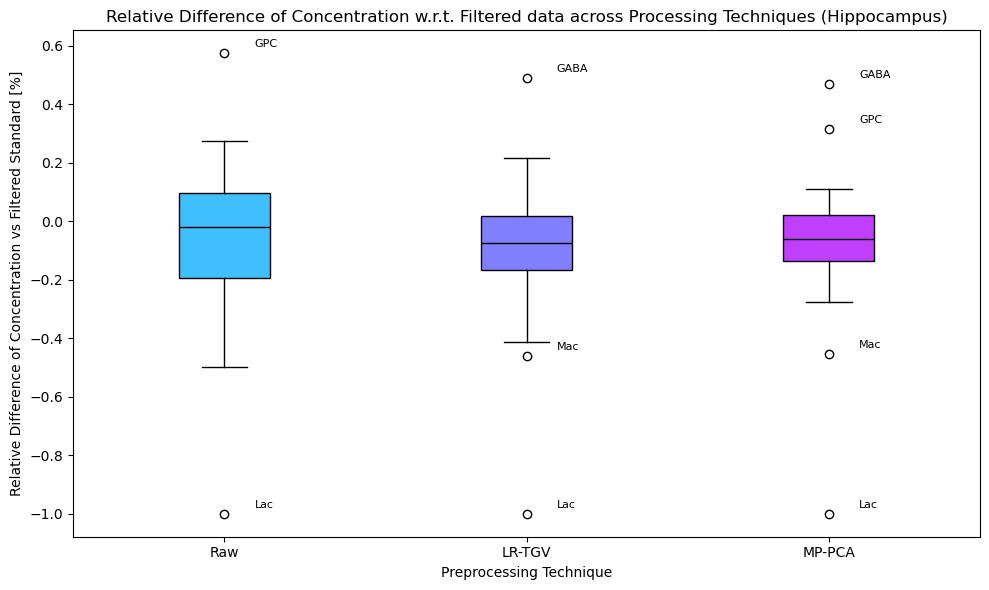

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
labels = ["Raw", "LR-TGV", "MP-PCA"]
y_data = [Raw_Hipp_vs_Filtered_mean, LR_Hipp_vs_Filtered_mean, MP_Hipp_vs_Filtered_mean]

# Create the boxplot
bplot = ax.boxplot(x=y_data, vert=True, patch_artist=True, tick_labels=labels)

plt.title('Relative Difference of Concentration w.r.t. Filtered data across Processing Techniques (Hippocampus)')
plt.xlabel('Preprocessing Technique')
plt.ylabel('Relative Difference of Concentration vs Filtered Standard [%]')

# Set the facecolor for each box
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Define the offset for labels
x_offset = 0.1  # Horizontal offset
y_offset = 0.02  # Vertical offset (can be negative or positive)

# Label the outliers
for i, (series, fliers) in enumerate(zip(y_data, bplot['fliers'])):
    y_outliers = fliers.get_ydata()  # Get the y-coordinates of the outliers
    for j, y in enumerate(y_outliers):
        index = series[series == y].index  # Get the index of the outlier
        if not index.empty:  # Check if an index was found
            # Adjust the x and y positions with the offsets
            ax.text(
                i + 1 + x_offset,  # Shift horizontally
                y + y_offset,      # Shift vertically
                f'{index[0]}', 
                ha='left', fontsize=8, color='black'
            )
# Change the color of the median lines
for median in bplot['medians']:
    median.set_color('black')
plt.tight_layout()
plt.show()


### Plot A.2)  Striatum

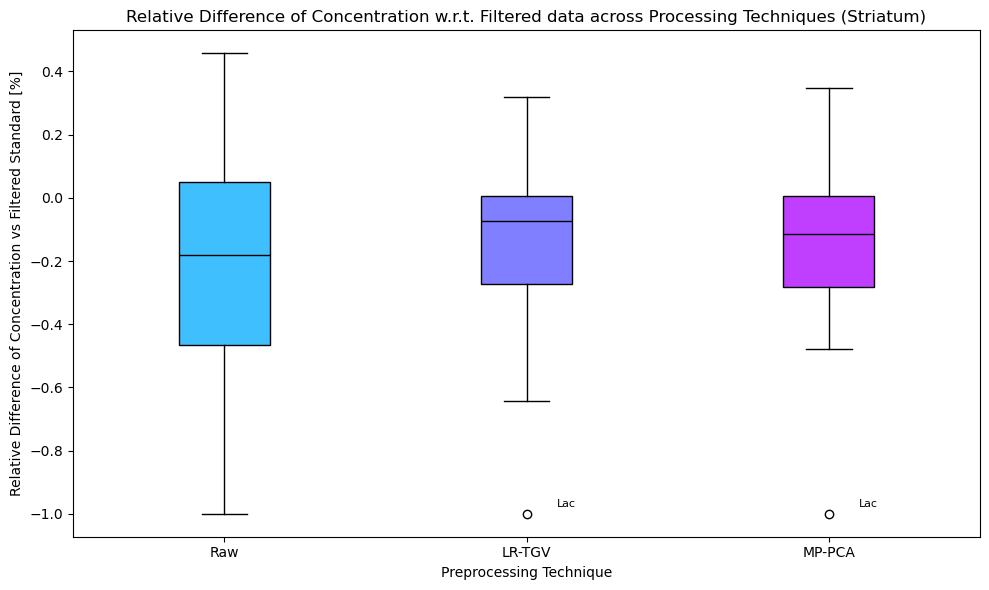

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))
labels = [ "Raw", "LR-TGV", "MP-PCA"]
y_data = [Raw_Stri_vs_Filtered_mean, LR_Stri_vs_Filtered_mean, MP_Stri_vs_Filtered_mean]

# Create the boxplot
bplot = ax.boxplot(x=y_data, vert=True, patch_artist=True, tick_labels=labels)

plt.title('Relative Difference of Concentration w.r.t. Filtered data across Processing Techniques (Striatum)')
plt.xlabel('Preprocessing Technique')
plt.ylabel('Relative Difference of Concentration vs Filtered Standard [%]')

# Set the facecolor for each box
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Define the offset for labels
x_offset = 0.1  # Horizontal offset
y_offset = 0.02  # Vertical offset (can be negative or positive)

# Label the outliers
for i, (series, fliers) in enumerate(zip(y_data, bplot['fliers'])):
    y_outliers = fliers.get_ydata()  # Get the y-coordinates of the outliers
    for j, y in enumerate(y_outliers):
        index = series[series == y].index  # Get the index of the outlier
        if not index.empty:  # Check if an index was found
            # Adjust the x and y positions with the offsets
            ax.text(
                i + 1 + x_offset,  # Shift horizontally
                y + y_offset,      # Shift vertically
                f'{index[0]}', 
                ha='left', fontsize=8, color='black'
            )
# Change the color of the median lines
for median in bplot['medians']:
    median.set_color('black')

#sns.despine()
plt.tight_layout()
plt.show()


## Plot B) Relative Difference of concentration for Each Metabolite Across the Processing Techniques
(Averaged over the 4 rats)

### Plot B.1) Hippocampus

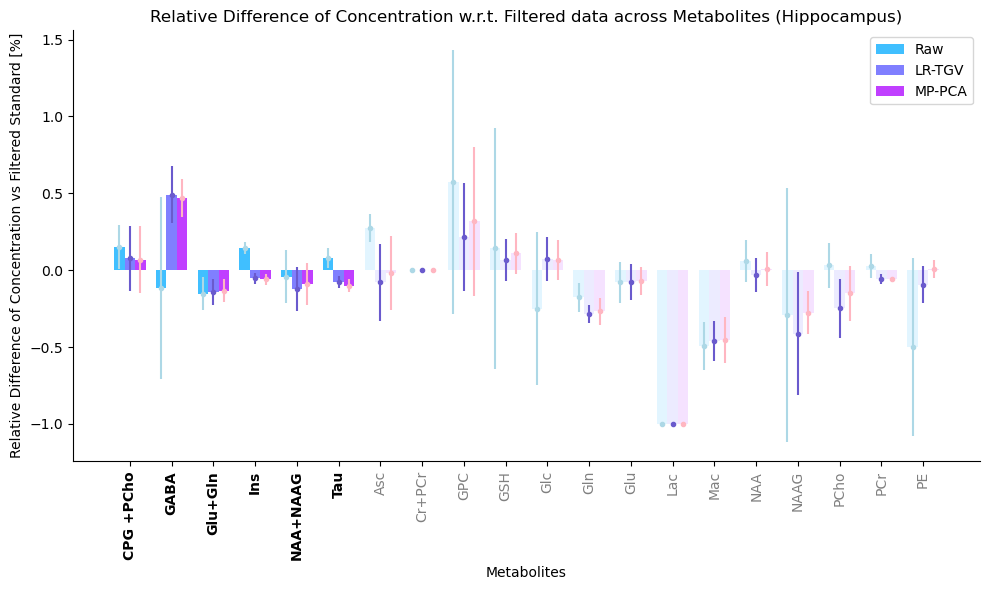

In [88]:
# Define the metabolites of interest for the hippocampus
MET_OF_INTEREST = {"Ins", "GABA", "Tau", "Glu+Gln", "NAA+NAAG", "CPG +PCho"}

# Sort the data by metabolites of interest first
sorted_keys = sorted(LR_Hipp_vs_Filtered_mean.keys(), key=lambda x: x not in MET_OF_INTEREST)

# Reorder the data based on sorted keys
LR_Hipp_vs_Filtered_mean = {key: LR_Hipp_vs_Filtered_mean[key] for key in sorted_keys}
Raw_Hipp_vs_Filtered_mean = {key: Raw_Hipp_vs_Filtered_mean[key] for key in sorted_keys}
MP_Hipp_vs_Filtered_mean = {key: MP_Hipp_vs_Filtered_mean[key] for key in sorted_keys}
Raw_Hipp_vs_Filtered_std = {key: Raw_Hipp_vs_Filtered_std[key] for key in sorted_keys}
LR_Hipp_vs_Filtered_std = {key: LR_Hipp_vs_Filtered_std[key] for key in sorted_keys}
MP_Hipp_vs_Filtered_std = {key: MP_Hipp_vs_Filtered_std[key] for key in sorted_keys}

X_axis = np.arange(len(LR_Hipp_vs_Filtered_mean))  # Shared x-axis for all categories

fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.25

# Plot the bars and emphasize metabolites of interest with a border
for i, key in enumerate(LR_Hipp_vs_Filtered_mean.keys()):
    if key in MET_OF_INTEREST:
        # Highlighted metabolites: Border around the bars
        ax.bar(X_axis[i] - bar_width, Raw_Hipp_vs_Filtered_mean[key], bar_width, color=colors[0], label='Raw' if i == 0 else "")
        ax.bar(X_axis[i], LR_Hipp_vs_Filtered_mean[key], bar_width, color=colors[1], label='LR-TGV' if i == 0 else "")
        ax.bar(X_axis[i] + bar_width, MP_Hipp_vs_Filtered_mean[key], bar_width, color=colors[2], label='MP-PCA' if i == 0 else "")
    else:
        # Non-highlighted metabolites with increased transparency (lower alpha)
        ax.bar(X_axis[i] - bar_width, Raw_Hipp_vs_Filtered_mean[key], bar_width, color=colors[0], alpha=0.15)
        ax.bar(X_axis[i], LR_Hipp_vs_Filtered_mean[key], bar_width, color=colors[1], alpha=0.15)
        ax.bar(X_axis[i] + bar_width, MP_Hipp_vs_Filtered_mean[key], bar_width, color=colors[2], alpha=0.15)

    # Add error bars
    ax.errorbar(X_axis[i] - bar_width, Raw_Hipp_vs_Filtered_mean[key], yerr=Raw_Hipp_vs_Filtered_std[key], fmt='.', color="lightblue")
    ax.errorbar(X_axis[i], LR_Hipp_vs_Filtered_mean[key], yerr=LR_Hipp_vs_Filtered_std[key], fmt='.', color="slateblue")
    ax.errorbar(X_axis[i] + bar_width, MP_Hipp_vs_Filtered_mean[key], yerr=MP_Hipp_vs_Filtered_std[key], fmt='.', color="lightpink")

# Set x-axis ticks and labels
ax.set_xticks(X_axis)
ax.set_xticklabels(LR_Hipp_vs_Filtered_mean.keys())

# Highlight the x-axis labels for metabolites of interest
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() in MET_OF_INTEREST:
        label.set_fontweight('bold')
    else:
        label.set_color('gray')  

plt.xticks(rotation=90)

# Titles and labels
ax.set_title("Relative Difference of Concentration w.r.t. Filtered data across Metabolites (Hippocampus)")
plt.xlabel("Metabolites")
plt.ylabel('Relative Difference of Concentration vs Filtered Standard [%]')

# Legend and styling
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


### Plot B.2) Striatum

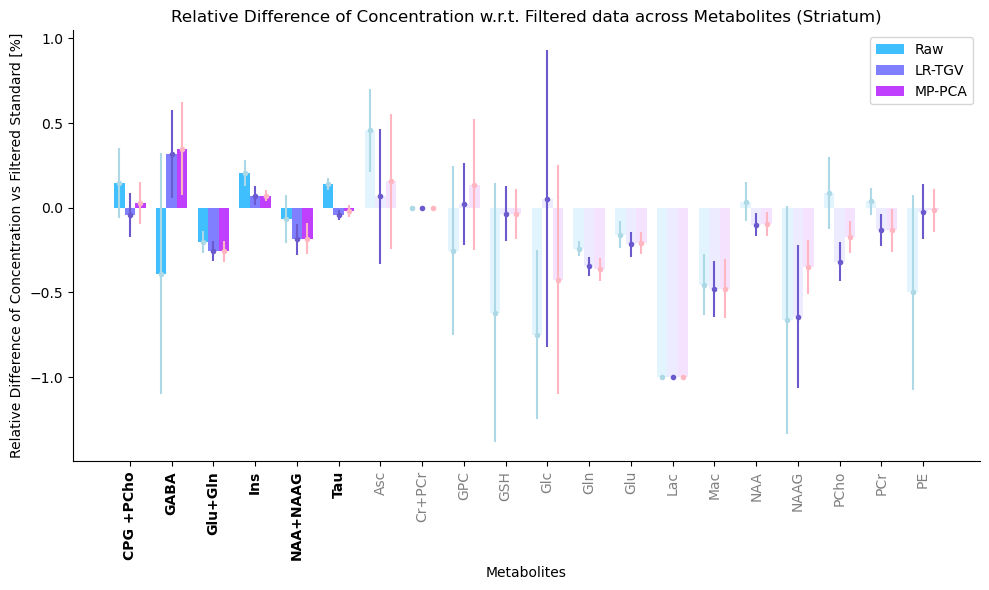

In [89]:
# Sort the data by metabolites of interest first
sorted_keys = sorted(LR_Stri_vs_Filtered_mean.keys(), key=lambda x: x not in MET_OF_INTEREST)

# Reorder the data based on sorted keys
LR_Stri_vs_Filtered_mean = {key: LR_Stri_vs_Filtered_mean[key] for key in sorted_keys}
Raw_Stri_vs_Filtered_mean = {key: Raw_Stri_vs_Filtered_mean[key] for key in sorted_keys}
MP_Stri_vs_Filtered_mean = {key: MP_Stri_vs_Filtered_mean[key] for key in sorted_keys}
Raw_Stri_vs_Filtered_std = {key: Raw_Stri_vs_Filtered_std[key] for key in sorted_keys}
LR_Stri_vs_Filtered_std = {key: LR_Stri_vs_Filtered_std[key] for key in sorted_keys}
MP_Stri_vs_Filtered_std = {key: MP_Stri_vs_Filtered_std[key] for key in sorted_keys}

X_axis = np.arange(len(LR_Stri_vs_Filtered_mean))  # Shared x-axis for all categories

fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.25

# Plot the bars and emphasize metabolites of interest with a border
for i, key in enumerate(LR_Stri_vs_Filtered_mean.keys()):
    if key in MET_OF_INTEREST:
        # Highlighted metabolites: Border around the bars
        ax.bar(X_axis[i] - bar_width, Raw_Stri_vs_Filtered_mean[key], bar_width, color=colors[0], label='Raw' if i == 0 else "")
        ax.bar(X_axis[i], LR_Stri_vs_Filtered_mean[key], bar_width, color=colors[1], label='LR-TGV' if i == 0 else "")
        ax.bar(X_axis[i] + bar_width, MP_Stri_vs_Filtered_mean[key], bar_width, color=colors[2], label='MP-PCA' if i == 0 else "")
    else:
        # Non-highlighted metabolites with increased transparency (lower alpha)
        ax.bar(X_axis[i] - bar_width, Raw_Stri_vs_Filtered_mean[key], bar_width, color=colors[0], alpha=0.15)
        ax.bar(X_axis[i], LR_Stri_vs_Filtered_mean[key], bar_width, color=colors[1], alpha=0.15)
        ax.bar(X_axis[i] + bar_width, MP_Stri_vs_Filtered_mean[key], bar_width, color=colors[2], alpha=0.15)

    # Add error bars
    ax.errorbar(X_axis[i] - bar_width, Raw_Stri_vs_Filtered_mean[key], yerr=Raw_Stri_vs_Filtered_std[key], fmt='.', color="lightblue")
    ax.errorbar(X_axis[i], LR_Stri_vs_Filtered_mean[key], yerr=LR_Stri_vs_Filtered_std[key], fmt='.', color="slateblue")
    ax.errorbar(X_axis[i] + bar_width, MP_Stri_vs_Filtered_mean[key], yerr=MP_Stri_vs_Filtered_std[key], fmt='.', color="lightpink")

# Set x-axis ticks and labels
ax.set_xticks(X_axis)
ax.set_xticklabels(LR_Stri_vs_Filtered_mean.keys())

# Highlight the x-axis labels for metabolites of interest
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() in MET_OF_INTEREST:
        label.set_fontweight('bold')
    else:
        label.set_color('gray')  

plt.xticks(rotation=90)

# Titles and labels
ax.set_title("Relative Difference of Concentration w.r.t. Filtered data across Metabolites (Striatum)")
plt.xlabel("Metabolites")
plt.ylabel('Relative Difference of Concentration vs Filtered Standard [%]')

# Legend and styling
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


## Plot C) Inconcistencies of Concentration across Processing Techniques vs Concentration of the Metabolites

In [42]:
# LR-TGV vs MP-PCA
MP_vs_LR_Hipp_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Hippocampus')][['mean_conc', 'mean_diff_MP_vs_LR']]
MP_vs_LR_Stri_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Striatum')][['mean_conc', 'mean_diff_MP_vs_LR']]

# LR-TGV vs Filter
Filtered_vs_LR_Hipp_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Hippocampus')][['mean_conc', 'mean_diff_vs_filtered']]
Filtered_vs_LR_Stri_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Striatum')][['mean_conc', 'mean_diff_vs_filtered']]

# MP-PCA vs Filter
Filtered_vs_MP_Hipp_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Hippocampus')][['mean_conc', 'mean_diff_vs_filtered']]
Filtered_vs_MP_Stri_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Striatum')][['mean_conc', 'mean_diff_vs_filtered']]


### Plot C.1) Hippocampus

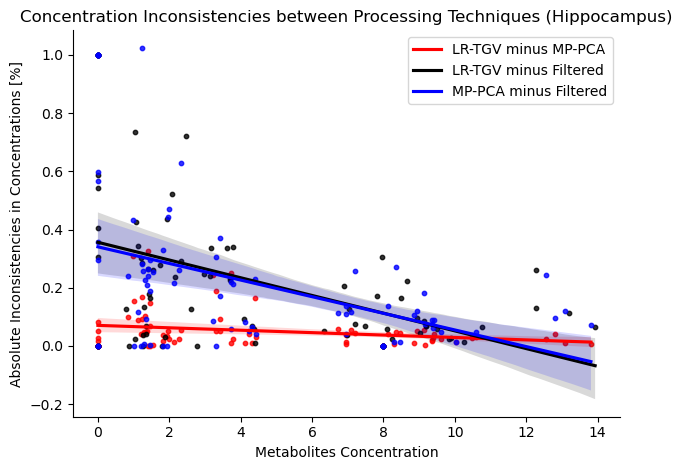

In [68]:
# Create the figure and axes
fig, ax = plt.subplots()

# Plot scatter and regression lines for each comparison
sns.regplot(
    x=MP_vs_LR_Hipp_mean.mean_conc,
    y=abs(MP_vs_LR_Hipp_mean.mean_diff_MP_vs_LR),
    scatter_kws={'color': 'r', 's': 10},
    line_kws={'label': 'LR-TGV minus MP-PCA', 'color': 'r'},
    ci=95,  # Confidence interval
    ax=ax,
)

sns.regplot(
    x=Filtered_vs_LR_Hipp_mean.mean_conc,
    y=abs(Filtered_vs_LR_Hipp_mean.mean_diff_vs_filtered),
    scatter_kws={'color': 'black', 's': 10},
    line_kws={'label': 'LR-TGV minus Filtered', 'color': 'black'},
    ci=95,
    ax=ax,
)

sns.regplot(
    x=Filtered_vs_MP_Hipp_mean.mean_conc,
    y=abs(Filtered_vs_MP_Hipp_mean.mean_diff_vs_filtered),
    scatter_kws={'color': 'blue', 's': 10},
    line_kws={'label': 'MP-PCA minus Filtered', 'color': 'blue'},
    ci=95,
    ax=ax,
)

# Add labels, title, and legend
ax.set_ylabel("Absolute Inconsistencies in Concentrations [%]")
ax.set_xlabel("Metabolites Concentration")
ax.set_title("Concentration Inconsistencies between Processing Techniques (Hippocampus)")
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

### Plot C.2) Striatum

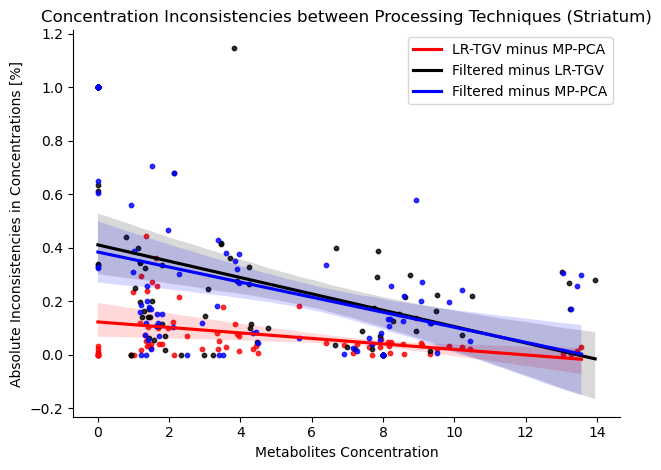

In [69]:
# Create the figure and axes
fig, ax = plt.subplots()

# Plot scatter and regression lines for each comparison
sns.regplot(
    x=MP_vs_LR_Stri_mean.mean_conc,
    y=abs(MP_vs_LR_Stri_mean.mean_diff_MP_vs_LR),
    scatter_kws={'color': 'r', 's': 10},
    line_kws={'label': 'LR-TGV minus MP-PCA', 'color': 'r'},
    ci=95,  # Confidence interval
    ax=ax,
)

sns.regplot(
    x=Filtered_vs_LR_Stri_mean.mean_conc,
    y=abs(Filtered_vs_LR_Stri_mean.mean_diff_vs_filtered),
    scatter_kws={'color': 'black', 's': 10},
    line_kws={'label': 'Filtered minus LR-TGV', 'color': 'black'},
    ci=95,
    ax=ax,
)

sns.regplot(
    x=Filtered_vs_MP_Stri_mean.mean_conc,
    y=abs(Filtered_vs_MP_Stri_mean.mean_diff_vs_filtered),
    scatter_kws={'color': 'blue', 's': 10},
    line_kws={'label': 'Filtered minus MP-PCA', 'color': 'blue'},
    ci=95,
    ax=ax,
)

# Add labels, title, and legend
ax.set_ylabel("Absolute Inconsistencies in Concentrations [%]")
ax.set_xlabel("Metabolites Concentration")
ax.set_title("Concentration Inconsistencies between Processing Techniques (Striatum)")
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()
